# Global Shallow Water Model, using SHTns

This Google Colab notebook sets up and runs a global shallow water model, based on the spectral transform method using the SHTns package by Nathanaël Schaeffer. The code is from:

https://bitbucket.org/nschaeff/shtns/src/master/

The model runs the non-linear barotropically unstable shallow water test case, based on the example provided by Jeffrey Whitaker:
 https://gist.github.com/jswhit/3845307

The work of Nathanaël and Jeff, the availability of Google Colab, and support from NOAA MAPP NA20OAR4310424 is gratefully acknowledged.

If you find any errors, please contact: Mathew_Barlow@uml.edu.

Mathew Barlow <br>
Professor of Climate Science <br>
University of Massachusetts Lowell

**Note:** If you use the SHTns package for research, please cite this paper:

Schaeffer, N., 2013. Efficient spherical harmonic transforms aimed at pseudospectral numerical simulations. Geochemistry, Geophysics, Geosystems, 14(3), pp.751-758.  https://doi.org/10.1002/ggge.20071

### install the libraries SHTns needs

key library is FFTW, can take several seconds to install

In [1]:
# The %%capture command avoids a lot of text output below
# the cell but does not change anything and can be removed,
# especially if any debugging is needed

%%capture
!sudo apt-get install libfftw3-dev libblas-dev liblapack-dev

### install SHTns and cartopy

can take a minute or so to install both packages

In [2]:
%%capture
!pip install shtns

In [3]:
%%capture
!pip install cartopy

### import needed packages

In [4]:
import numpy as np
import shtns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from cartopy.util import add_cyclic_point

### define a wrapper for SHTns so that it works like pyspharm

In [5]:
# from Nathanaël Schaeffer

class Spharmt(object):
    """
    wrapper class for commonly used spectral transform operations in
    atmospheric models.  Provides an interface to shtns compatible
    with pyspharm (pyspharm.googlecode.com).
    """
    def __init__(self, nlons, nlats, ntrunc, rsphere, gridtype="gaussian"):
        """initialize
        nlons:  number of longitudes
        nlats:  number of latitudes"""
        self._shtns = shtns.sht(ntrunc, ntrunc, 1,
                                shtns.sht_orthonormal+shtns.SHT_NO_CS_PHASE)

        if gridtype == "gaussian":
            # self._shtns.set_grid(nlats, nlons,
            #         shtns.sht_gauss_fly | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)
            self._shtns.set_grid(nlats, nlons,
                    shtns.sht_quick_init | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)
        elif gridtype == "regular":
            self._shtns.set_grid(nlats, nlons,
                    shtns.sht_reg_dct | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)

        self.lats = np.arcsin(self._shtns.cos_theta)
        self.lons = (2.*np.pi/nlons)*np.arange(nlons)
        self.nlons = nlons
        self.nlats = nlats
        self.ntrunc = ntrunc
        self.nlm = self._shtns.nlm
        self.degree = self._shtns.l
        self.lap = -self.degree*(self.degree+1.0).astype(complex)
        self.invlap = np.zeros(self.lap.shape, self.lap.dtype)
        self.invlap[1:] = 1./self.lap[1:]
        self.rsphere = rsphere
        self.lap = self.lap/rsphere**2
        self.invlap = self.invlap*rsphere**2

    def grdtospec(self, data):
        """compute spectral coefficients from gridded data"""
        return self._shtns.analys(data)

    def spectogrd(self, dataspec):
        """compute gridded data from spectral coefficients"""
        return self._shtns.synth(dataspec)

    def getuv(self, vrtspec, divspec):
        """compute wind vector from spectral coeffs of vorticity and divergence"""
        return self._shtns.synth((self.invlap/self.rsphere)*vrtspec, (self.invlap/self.rsphere)*divspec)

    def getvrtdivspec(self, u, v):
        """compute spectral coeffs of vorticity and divergence from wind vector"""
        vrtspec, divspec = self._shtns.analys(u, v)
        return self.lap*self.rsphere*vrtspec, self.lap*rsphere*divspec

    def getgrad(self, divspec):
        """compute gradient vector from spectral coeffs"""
        vrtspec = np.zeros(divspec.shape, dtype=complex)
        u, v = self._shtns.synth(vrtspec, divspec)
        return u/rsphere, v/rsphere


### run the model

when re-running model, need to run all three cells in this section

set up model and choose parameters

In [6]:
# from Nathanaël Schaeffer / Jeff Whitaker

# grid, time step info
nlons = 256                 # number of longitudes
ntrunc = int(nlons/3)       # spectral truncation (for alias-free computations)
nlats = int(nlons/2)        # for gaussian grid.
dt = 150                    # time step in seconds
itmax = 6*int(86400/dt)     # integration length in days

# parameters for test
rsphere = 6.37122e6         # earth radius
omega = 7.292e-5            # rotation rate
grav = 9.80616              # gravity
hbar = 10.e3                # resting depth
umax = 80.                  # jet speed
phi0 = np.pi/7.
phi1 = 0.5*np.pi - phi0
phi2 = 0.25*np.pi
en = np.exp(-4.0/(phi1-phi0)**2)
alpha = 1./3.
beta = 1./15.
hamp = 120.                 # amplitude of height perturbation to zonal jet
efold = 3.*3600.            # efolding timescale at ntrunc for hyperdiffusion
ndiss = 8                   # order for hyperdiffusion

# setup up spherical harmonic instance, set lats/lons of grid
x = Spharmt(nlons, nlats, ntrunc, rsphere, gridtype="gaussian")
lons, lats = np.meshgrid(x.lons, x.lats)
f = 2.*omega*np.sin(lats)   # coriolis

# zonal jet.
vg = np.zeros((nlats, nlons), float)
u1 = (umax/en)*np.exp(1./((x.lats-phi0)*(x.lats-phi1)))
ug = np.zeros((nlats), float)
ug = np.where(np.logical_and(x.lats < phi1, x.lats > phi0), u1, ug)
ug.shape = (nlats, 1)
ug = ug*np.ones((nlats, nlons), dtype=float)     # broadcast to shape (nlats, nlonss)
# height perturbation.
hbump = hamp*np.cos(lats)*np.exp(-((lons-np.pi)/alpha)**2)*np.exp(-(phi2-lats)**2/beta)

# initial vorticity, divergence in spectral space
vrtspec, divspec = x.getvrtdivspec(ug, vg)
vrtg = x.spectogrd(vrtspec)
divg = x.spectogrd(divspec)

# create hyperdiffusion factor
hyperdiff_fact = np.exp((-dt/efold)*(x.lap/x.lap[-1])**(ndiss/2))

# solve nonlinear balance eqn to get initial zonal geopotential,
# add localized bump (not balanced).
vrtg = x.spectogrd(vrtspec)
tmpg1 = ug*(vrtg+f)
tmpg2 = vg*(vrtg+f)
tmpspec1, tmpspec2 = x.getvrtdivspec(tmpg1, tmpg2)
tmpspec2 = x.grdtospec(0.5*(ug**2+vg**2))
phispec = x.invlap*tmpspec1 - tmpspec2
phig = grav*(hbar + hbump) + x.spectogrd(phispec)
phispec = x.grdtospec(phig)

# initialize spectral tendency arrays
ddivdtspec = np.zeros(vrtspec.shape+(3,), complex)
dvrtdtspec = np.zeros(vrtspec.shape+(3,), complex)
dphidtspec = np.zeros(vrtspec.shape+(3,), complex)
nnew = 0
nnow = 1
nold = 2

set up output variables

In [7]:
# set up output variables

nsecs_out = 60*60           # output step in seconds
nt_out = int(itmax*dt/nsecs_out) + 1 # number of outputs (including init)
phig_out = np.zeros((nt_out, nlats, nlons))
vrtg_out = np.zeros((nt_out, nlats, nlons))
secs_out = np.zeros(nt_out)
iout = 0

loop through time integration

In [8]:
# from Nathanaël Schaeffer / Jeff Whitaker

# time loop.
time1 = time.time()
for ncycle in range(itmax+1):
    t = ncycle*dt
    # get vort, u, v, phi on grid
    vrtg = x.spectogrd(vrtspec)
    ug, vg = x.getuv(vrtspec, divspec)
    phig = x.spectogrd(phispec)

    if np.mod(t, nsecs_out)==0:
      phig_out[iout, :, :] = phig
      vrtg_out[iout, :, :] = vrtg
      secs_out[iout] = t
      iout += 1

    if np.mod(t, 24*60*60)==0:
      print("t=%6.2f hours: min/max %6.2f, %6.2f" % (t/3600., vg.min(), vg.max()))

    # compute tendencies.
    tmpg1 = ug*(vrtg+f)
    tmpg2 = vg*(vrtg+f)
    ddivdtspec[:, nnew], dvrtdtspec[:, nnew] = x.getvrtdivspec(tmpg1, tmpg2)
    dvrtdtspec[:, nnew] *= -1

    tmpg = x.spectogrd(ddivdtspec[:, nnew])
    tmpg1 = ug*phig
    tmpg2 = vg*phig
    tmpspec, dphidtspec[:, nnew] = x.getvrtdivspec(tmpg1, tmpg2)
    dphidtspec[:, nnew] *= -1

    tmpspec = x.grdtospec(phig+0.5*(ug**2+vg**2))
    ddivdtspec[:, nnew] += -x.lap*tmpspec

    # update vort, div, phiv with third-order adams-bashforth.
    # forward euler, then 2nd-order adams-bashforth time steps to start.
    if ncycle == 0:
        dvrtdtspec[:, nnow] = dvrtdtspec[:, nnew]
        dvrtdtspec[:, nold] = dvrtdtspec[:, nnew]
        ddivdtspec[:, nnow] = ddivdtspec[:, nnew]
        ddivdtspec[:, nold] = ddivdtspec[:, nnew]
        dphidtspec[:, nnow] = dphidtspec[:, nnew]
        dphidtspec[:, nold] = dphidtspec[:, nnew]
    elif ncycle == 1:
        dvrtdtspec[:, nold] = dvrtdtspec[:, nnew]
        ddivdtspec[:, nold] = ddivdtspec[:, nnew]
        dphidtspec[:, nold] = dphidtspec[:, nnew]

    vrtspec += dt*(
        (23./12.)*dvrtdtspec[:, nnew] - (16./12.)*dvrtdtspec[:, nnow]
        + (5./12.)*dvrtdtspec[:, nold])
    divspec += dt*(
        (23./12.)*ddivdtspec[:, nnew] - (16./12.)*ddivdtspec[:, nnow]
        + (5./12.)*ddivdtspec[:, nold])
    phispec += dt*(
        (23./12.)*dphidtspec[:, nnew] - (16./12.)*dphidtspec[:, nnow]
        + (5./12.)*dphidtspec[:, nold])
    # implicit hyperdiffusion for vort and div.
    vrtspec *= hyperdiff_fact
    divspec *= hyperdiff_fact
    # switch indices, do next time step.
    nsav1 = nnew
    nsav2 = nnow
    nnew = nold
    nnow = nsav1
    nold = nsav2


time2 = time.time()
print("CPU time = ", time2-time1)

t=  0.00 hours: min/max   0.00,   0.00
t= 24.00 hours: min/max  -1.00,   1.06
t= 48.00 hours: min/max  -3.71,   3.78
t= 72.00 hours: min/max -16.11,  14.73
t= 96.00 hours: min/max -48.56,  43.26
t=120.00 hours: min/max -56.47,  47.74
t=144.00 hours: min/max -53.58,  44.62
CPU time =  19.78854203224182


### plot the results

make a plot of the output

(coastlines are shown for scale but no terrain features are present in the model)

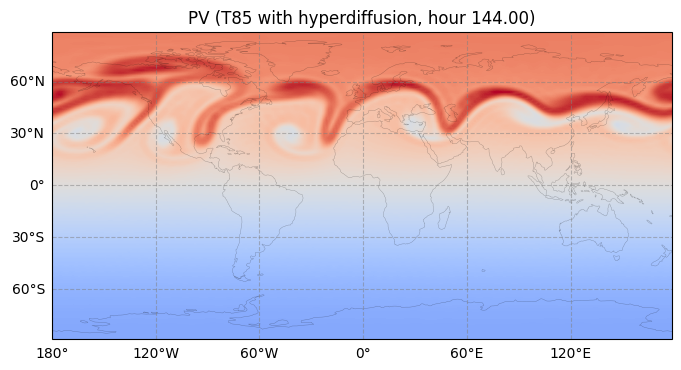

In [9]:
fig, ax = plt.subplots(1, 1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8, 4))

# dimensionless PV
pvg = (0.5*hbar*grav/omega)*(vrtg+f)/phig
#print("max/min PV", pvg.min(), pvg.max())
lons1d = (180./np.pi)*x.lons-180.
lats1d = (180./np.pi)*x.lats
levs = np.arange(-1.8, 1.8, 0.01)

cs = ax.contourf(lons1d, lats1d, pvg, levs, extend="both", cmap="coolwarm",
                 transform=ccrs.PlateCarree())

ax.set_title("PV (T%s with hyperdiffusion, hour %6.2f)" % (ntrunc, t/3600.))

ax.coastlines(resolution='110m', linewidth=0.3, alpha=0.3)
gl = ax.gridlines(alpha=0.5, crs=ccrs.PlateCarree(), draw_labels=True,
                  color='gray', linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.show()

plot just the NH

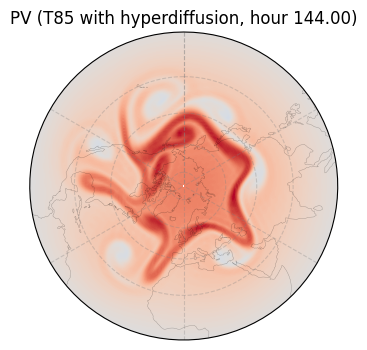

In [10]:
fig, ax = plt.subplots(1, 1,
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        figsize=(8, 4))

# dimensionless PV
pvg = (0.5*hbar*grav/omega)*(vrtg+f)/phig
#print("max/min PV", pvg.min(), pvg.max())
lons1d = (180./np.pi)*x.lons-180.
lats1d = (180./np.pi)*x.lats
levs = np.arange(-1.8, 1.8, 0.01)

nyhalf = int(lats1d.size/2)
latsNH = lats1d[0:nyhalf]
pvgNH = pvg[0:nyhalf, :]

pvgNH, lonNH = add_cyclic_point(pvgNH, coord=lons1d)

cs = ax.contourf(lonNH, latsNH, pvgNH, levs, extend="both", cmap="coolwarm",
                 transform=ccrs.PlateCarree())

ax.set_title("PV (T%s with hyperdiffusion, hour %6.2f)" % (ntrunc, t/3600.))

ax.coastlines(resolution='110m', linewidth=0.3, alpha=0.3)
gl = ax.gridlines(alpha=0.3, crs=ccrs.PlateCarree(),
                  color='gray', linestyle='--')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

plt.show()

plot for a series of times

In [11]:
# choose times for output
out_times = [0, 48, 96, 144]

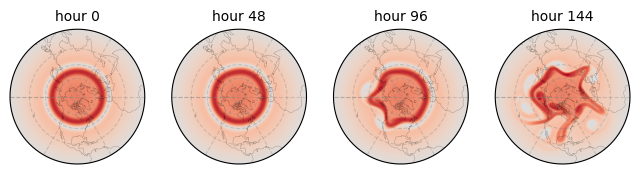

In [12]:
plt.figure(figsize=(8, 4))
crs = ccrs.PlateCarree()

n = len(out_times)
for i in range(n):
  ax = plt.subplot(1, n, i+1, projection= ccrs.NorthPolarStereo(central_longitude=-90))
  # dimensionless PV
  it = out_times[i]
  t = secs_out[it]
  pvg = (0.5*hbar*grav/omega)*(vrtg_out[it, :, :]+f)/phig_out[it, :, :]
  #print("max/min PV", pvg.min(), pvg.max())
  lons1d = (180./np.pi)*x.lons-180.
  lats1d = (180./np.pi)*x.lats
  levs = np.arange(-1.8, 1.8, 0.01)

  nyhalf = int(lats1d.size/2)
  latsNH = lats1d[0:nyhalf]
  pvgNH = pvg[0:nyhalf, :]

  pvgNH, lonNH = add_cyclic_point(pvgNH, coord=lons1d)

  cs = ax.contourf(lonNH, latsNH, pvgNH, levs, extend="both", cmap="coolwarm",
                  transform=ccrs.PlateCarree())

  ax.set_title("hour " + str(int(t/3600)), fontsize=10)

  ax.coastlines(resolution='110m', linewidth=0.3, alpha=0.3)
  gl = ax.gridlines(alpha=0.3, crs=ccrs.PlateCarree(),
                    color='gray', linestyle='--')

  theta = np.linspace(0, 2*np.pi, 100)
  center, radius = [0.5, 0.5], 0.5
  verts = np.vstack([np.sin(theta), np.cos(theta)]).T
  circle = mpath.Path(verts * radius + center)
  ax.set_boundary(circle, transform=ax.transAxes)